# Anomaly Detection in E-Commerse

## Preparations

The following modules will be used:

* `asqlcell` for analytical SQL capabilities.
* `scikit-learn` for machine learning.

The installation is simple as:

In [ ]:
%pip install asqlcell scikit-learn --upgrade

Simply load `asqlcell` and we'll be all set:

In [ ]:
%load_ext asqlcell

## Data

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Observation

We can use SQL statements to inspect data:

In [ ]:
%%sql

SELECT *
FROM 'ecommerce.csv.gz'
LIMIT 20

The data is quite straightforward to understand.

However, there are two potential improvements:

1. Invoice date is not standard. We would like to convert to SQL timestamp and then get first date of that week.
2. We'd like to calculate total sales by multiplying unit price with quantity.

We can transform the data with the following SQL statement and then store the result in holder variable.

In [ ]:
%%sql -o holder

SELECT
    date_trunc('week', strptime(split_part(InvoiceDate, ' ', 1), '%m/%d/%Y')) AS Date,
    Quantity * UnitPrice AS Sales,
    InvoiceNo,
    CustomerID,
    Country,
FROM 'ecommerce.csv.gz'
WHERE StockCode='85123A'

Now we'd like to aggregate the sales by week so that we can inspect the weekly total sales trend:

In [ ]:
%%sql -o aggregated

SELECT
    Date,
    SUM(Sales) AS Total
FROM holder
GROUP BY Date

It is still very hard to find the anomalies just by looking at the visuals. However, with the help of Isolation Forest algorithm, it would be much easier.

Isolation Forest is an unsupervised machine learning algorithm for anomaly detection. As the name implies, Isolation Forest is an ensemble method similar to random forest. In other words, it use the average of the predictions by several decision trees when assigning the final anomaly score to a given data point.

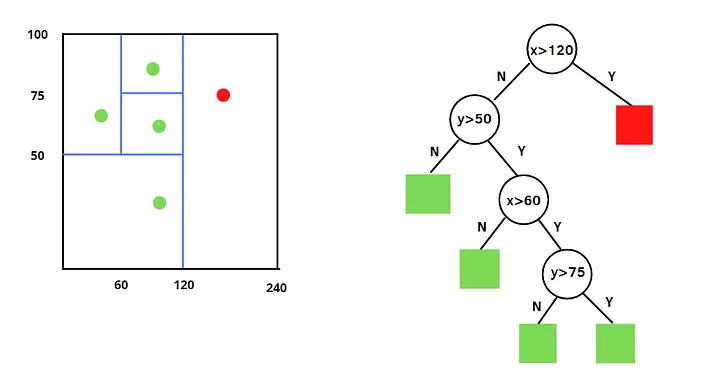

We'll use the implementation of Scikit Learn to achieve this.

In [ ]:
from sklearn.ensemble import IsolationForest

detector = IsolationForest(contamination=.1)
detector.fit(aggregated[['Total']])

And then predict anomalies by the model.

In [ ]:
predicted = detector.predict(aggregated[['Total']])
print(predicted)

Last but not least, we can merge the train data with predict result with positional join statement.

In [ ]:
%%sql

SELECT
    aggregated.*, predicted.column0 AS Type
FROM aggregated POSITIONAL JOIN predicted

Now it is very easy to identify the anomalies.